In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Model, Sequential
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Conv2DTranspose,\
                                    Reshape, ReLU, LeakyReLU,BatchNormalization, Lambda, \
                                    UpSampling2D, Softmax, Input, Dropout, AvgPool2D, Concatenate, \
                                    LocallyConnected2D, SpatialDropout2D, Activation, InputLayer, \
                                    GaussianNoise
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

In [2]:
tf.__version__

'2.0.0'

In [9]:
with np.load('/home/etheredge/Workspace/tcvae/data/gan_generated_guppies_fewer_samples.npz') as f:
    gan_images, gan_labels = f['x_train'], f['y_train'].astype('int')
real_images = np.load("/home/etheredge/Workspace/tcvae/data/imgs_trainVAE.npy")
real_labels = np.load("/home/etheredge/Workspace/tcvae/data/lines_trainVAE.npy")
brooks_images = np.load('/mnt/jordanlab/People/ietheredge/Guppies_Final/pattern_space/data/brooks_imgs_256.npy')
brooks_attrs = np.load('/mnt/jordanlab/People/ietheredge/Guppies_Final/pattern_space/data/brooks_attrs.npy')

In [10]:
# images = gan_images
# images_class = gan_labels
images = np.concatenate([gan_images, real_images, brooks_images])
# images = real_images
# image_class = real_labels
# images = brooks_images
# images_class = brooks_attrs[:,1]
images = images.astype('float32')
images = images / images.max().max()

In [11]:
images.shape

(14221, 256, 256, 3)

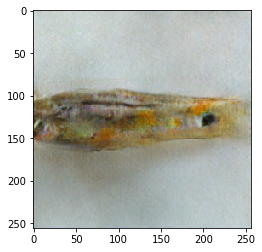

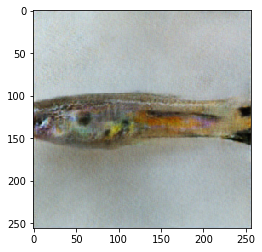

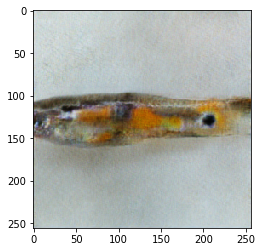

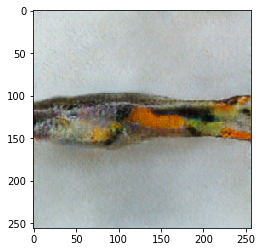

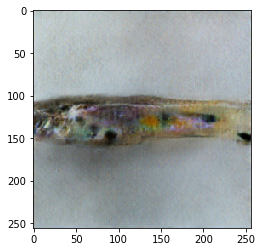

In [12]:
for i in np.random.randint(0,  len(images)-1, 5):
    plt.imshow(images[i])
    plt.show()

In [13]:
tf.keras.backend.clear_session()
gc.collect()

11920

In [14]:
class SaltAndPepper(tf.keras.layers.Layer):

    def __init__(self, ratio=0.9, **kwargs):
        super(SaltAndPepper, self).__init__(**kwargs)
        self.supports_masking = True
        self.ratio = ratio

    def call(self, inputs, training=None):
        def noised():
            shp = K.shape(inputs)[1:]
            mask_select = K.random_binomial(shape=shp, p=self.ratio)
            mask_noise = K.random_binomial(shape=shp, p=0.1) # salt and pepper have the same chance
            out = (inputs * (mask_select)) + mask_noise
            return out

        return K.in_train_phase(noised(), inputs, training=training)

    def get_config(self):
        config = {'ratio': self.ratio,
                  'supports_masking': self.supports_masking}
        base_config = super(SaltAndPepper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [30]:
class NormalVariational(tf.keras.layers.Layer):
    
    def __init__(self, size, mu_prior=0., sigma_prior=1., add_kl=False, coef_kl = 1.0, add_mmd=True, use_homm=False, homm_order=3, lambda_mmd=1.0, kernel_f=None, name=None):
        super().__init__(name=name)
        self.add_kl = add_kl
        self.add_mmd = add_mmd
        self.use_homm = use_homm
        self.order_homm = homm_order
        self.lambda_mmd = lambda_mmd
        if kernel_f is None:
            self.kernel_f = self._rbf
        else:
            self.kernel_f = kernel_f

        self.mu_layer = tf.keras.layers.Dense(size)
        self.sigma_layer = tf.keras.layers.Dense(size)
        self.mu_prior = tf.constant(mu_prior, dtype=tf.float32, shape=(size,))
        self.sigma_prior = tf.constant(sigma_prior, dtype=tf.float32, shape=(size,))
        self.coef_kl = tf.Variable(coef_kl, trainable=False, name='coef_kl')

            
    def _rbf(self, x, y):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
        tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
        return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))
    
    def _linear(self, x,y):
        return tf.reduce_sum(tf.multiply(x,y))

    def add_kl_divergence(self, q_mu, q_sigma, p_mu, p_sigma):
        r = q_mu - p_mu
        kl = tf.reduce_mean(self.coef_kl * tf.reduce_sum(tf.math.log(p_sigma) - tf.math.log(q_sigma) - .5 * (1. - (q_sigma**2 + r**2) / p_sigma**2), axis=1))
        self.add_loss(kl)
        self.add_metric(kl, 'mean', 'kl_divergence')

    def add_mmd_discrepancy(self, z, z_prior):
        k_prior = self.kernel_f(z_prior, z_prior)
        k_post = self.kernel_f(z, z)
        k_prior_post = self.kernel_f(z_prior, z)
        mmd = tf.reduce_mean(k_prior) + tf.reduce_mean(k_post) - 2 * tf.reduce_mean(k_prior_post)
        mmd = tf.multiply(self.lambda_mmd,  mmd, name='mmd')
        self.add_loss(mmd)
        self.add_metric(mmd, 'mean', 'mmd_discrepancy')

    def add_homm_discrepancy(self, x, y, order=3, num=300000):
        x = x - tf.reduce_mean(x, axis=0)
        y = y - tf.reduce_mean(y, axis=0)
        dim = tf.cast(x.shape[1], tf.int32)
        index = tf.random.uniform(shape=(num, dim), minval=0, maxval=dim-1, dtype=tf.int32)
        index = index[:, :order]
        x = tf.transpose(x)
        x = tf.gather(x, index)
        y = tf.transpose(y)
        y = tf.gather(y, index)
        ho_x = tf.reduce_prod(x, axis=1)
        ho_x = tf.reduce_mean(ho_x, axis=1)
        ho_y = tf.reduce_prod(y, axis=1)
        ho_y = tf.reduce_mean(ho_y, axis=1)
        homm_loss = tf.reduce_mean(tf.square(tf.subtract(ho_x, ho_y)))
        homm_loss = tf.multiply(self.lambda_mmd,  homm_loss, name='homm')
        self.add_loss(homm_loss)
        self.add_metric(homm_loss, 'mean', 'homm_discrepancy')

    def call(self, inputs):
        mu = self.mu_layer(inputs)
        log_sigma =  self.sigma_layer(inputs)
        sigma_square = tf.exp(log_sigma)
        if self.add_kl:
            self.add_kl_divergence(mu, sigma_square, self.mu_prior, self.sigma_prior)
            
        z = mu + sigma_square * tf.random.normal(tf.shape(sigma_square))
        if self.add_mmd:
            if self.use_homm:
                z_prior = tfp.distributions.MultivariateNormalDiag(self.mu_prior, self.sigma_prior).sample(tf.shape(z)[0])
                z_adapt = tf.tanh(z)
                z_prior_adapt = tf.tanh(z_prior)
                self.add_homm_discrepancy(z_adapt, z_prior_adapt, order=self.order_homm)

            else:
                z_prior = tfp.distributions.MultivariateNormalDiag(self.mu_prior, self.sigma_prior).sample(tf.shape(z)[0])
                self.add_mmd_discrepancy(z, z_prior)

        return z

    def get_config(self):
        base_config = super(NormalVariational, self).get_config()
        config = {
            'add_kl': self.add_kl,
            'add_mmd': self.add_mmd,
            'use_homm': self.use_homm,
            'order_homm': self.order_homm,
            'lambda_mmd': self.lambda_mmd,
        }
        return dict(list(base_config.items()) + list(config.items()))

In [31]:
def make_encoder(latent_size):
    
    inputs = Input((256,256,3))
    with tf.name_scope('noise'):
        noise_layers = Sequential([
            SaltAndPepper(),
            GaussianNoise(0.1)
            ], name='noise')
        noisy_inputs = noise_layers(inputs)

    with tf.name_scope('h_1'):
        h_1_layers = Sequential([ 
            Input((256, 256, 3)),
            Conv2D(64, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(64, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_1')
        h_1 = h_1_layers(noisy_inputs)
        h_1_flatten = Flatten()(h_1)

    with tf.name_scope('h_2'):
        h_2_layers = Sequential([ 
            Conv2D(128, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(128, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(256, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_2')
        h_2 = h_2_layers(h_1)
        h_2_flatten = Flatten()(h_2)

    with tf.name_scope('h_3'):
        h_3_layers = Sequential([ 
            Conv2D(256, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(512, 4, 2, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(512, 4, 1, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_3')
        h_3 = h_3_layers(h_2)
        h_3_flatten = Flatten()(h_3)

    with tf.name_scope('h_4'):
        h_4_layers = Sequential([ 
            Dense(1024, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU(),
            Dense(1024, kernel_regularizer=l2(2.5e-5),
                   kernel_initializer=tf.random_normal_initializer(stddev=0.02)),
            BatchNormalization(),
            LeakyReLU()], name='h_4')
        h_4 = h_4_layers(h_3)
        h_4_flatten = Flatten()(h_4)

    return Model(inputs, [h_1_flatten, h_2_flatten, h_3_flatten, h_4_flatten], name='encoder')

In [32]:
def make_decoder(latent_dim1, latent_dim2, latent_dim3, latent_dim4):
    z_1_input, z_2_input, z_3_input, z_4_input = Input((latent_dim1,), name='z_1'), Input((latent_dim2,), name='z_2'), Input((latent_dim3,), name='z_3'), Input((latent_dim4,), name='z_4')
    
    with tf.name_scope('z_tilde_4'):
        z_4 = z_4_input
        z_tilde_4_layers = Sequential([
            Dense(1024, kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Dense(1024, kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Dense(16*16*512, kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Reshape((16,16,512))], name='z_tilde_4')
        z_tilde_4 = z_tilde_4_layers(z_4)

    with tf.name_scope('z_tilde_3'):
        z_3 = Dense(16*16*512, kernel_regularizer=l2(2.5e-5))(z_3_input)
        z_3 = BatchNormalization()(z_3)
        z_3 = ReLU()(z_3)
        z_3 = Reshape((16,16,512))(z_3)
        z_tilde_3_layers = Sequential([
            Conv2DTranspose(512, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(256, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(256, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU()], name='z_tilde_3')
        input_z_tilde_3 = Concatenate()([z_tilde_4, z_3])
        z_tilde_3 = z_tilde_3_layers(input_z_tilde_3)
        
    with tf.name_scope('z_tilde_2'):
        z_2 = Dense(32*32*256, kernel_regularizer=l2(2.5e-5))(z_2_input)
        z_2 = BatchNormalization()(z_2)
        z_2 = ReLU()(z_2)
        z_2 = Reshape((32,32,256))(z_2)
        z_tilde_2_layers = Sequential([
            Conv2DTranspose(128, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(128, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(64, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            BatchNormalization(),
            ReLU()], name='z_tilde_2')
        input_z_tilde_2 = Concatenate()([z_tilde_3, z_2])
        z_tilde_2 =  z_tilde_2_layers(input_z_tilde_2)
    
    with tf.name_scope('z_tilde_1'):
        z_1 = Dense(128*128*64, kernel_regularizer=l2(2.5e-5))(z_1_input)
        z_1 = BatchNormalization()(z_1)
        z_1 = ReLU()(z_1)
        z_1 = Reshape((128,128,64))(z_1)
        z_tilde_1_layers = Sequential([
            Conv2DTranspose(128, 4, 2, padding='same', kernel_regularizer=l2(2.5e-5)),
            Conv2DTranspose(3, 4, 1, padding='same', kernel_regularizer=l2(2.5e-5)),
            Activation('sigmoid')], name='z_tilde_1')
        input_z_tilde_1 = Concatenate()([z_tilde_2, z_1])
        decoder =  z_tilde_1_layers(input_z_tilde_1)

    return Model([z_1_input, z_2_input, z_3_input, z_4_input], decoder, name='decoder')

In [33]:
def make_vlae(latent_size, use_perceptual_loss=False):
    with tf.name_scope('encoder'):
        encoder = make_encoder(latent_size)
    with tf.name_scope('decoder'):
        decoder = make_decoder(latent_size, latent_size, latent_size, latent_size)
    inputs = Input((256,256,3))
    h_1, h_2, h_3, h_4 = encoder(inputs)
    z_1 = NormalVariational(latent_size, add_kl=False, coef_kl=1., add_mmd=True, lambda_mmd=5000., name='z_1_latent')(h_1)
    z_2 = NormalVariational(latent_size, add_kl=False, coef_kl=1., add_mmd=True, lambda_mmd=5000., name='z_2_latent')(h_2)
    z_3 = NormalVariational(latent_size, add_kl=False, coef_kl=1., add_mmd=True, lambda_mmd=5000., name='z_3_latent')(h_3)
    z_4 = NormalVariational(latent_size, add_kl=False, coef_kl=1., add_mmd=True, lambda_mmd=5000., name='z_4_latent')(h_4)
    decoded = decoder([z_1, z_2, z_3, z_4])
    vlae = Model(inputs, decoded, name='vlae')
    return vlae

In [34]:
class KLWarmUp(tf.keras.callbacks.Callback):
    
    def __init__(self, vlae, n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
        self.frange = frange_cycle_linear(n_iter, start=start, stop=stop,  n_cycle=n_cycle, ratio=ratio)
        self.vlae = vlae
        self.epoch = 0
        
        
    def on_epoch_end(self, *args, **kwargs):
        new_coef = self.frange[self.epoch]
        self.epoch += 1
        coefs = [self.vlae.get_layer(f'z_{i+1}_latent').coef_kl for i in range(3)]
        for coef in coefs:
            coef.assign(new_coef)
    
    @staticmethod
    def frange_cycle_linear(n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
        L = np.ones(n_iter) * stop
        period = n_iter/n_cycle
        step = (stop-start)/(period*ratio) # linear schedule

        for c in range(n_cycle):
            v, i = start, 0
            while v <= stop and (int(i+c*period) < n_iter):
                L[int(i+c*period)] = v
                v += step
                i += 1
        return L 

In [35]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 31303), started 12:13:54 ago. (Use '!kill 31303' to kill it.)

In [36]:
latent_size = 10
vlae = make_vlae(latent_size)

In [37]:
epochs = 500
tb = TensorBoard(write_images=False, write_graph=True, histogram_freq=25)
es = EarlyStopping(min_delta=0.0001, patience=15)
# klwarmup = KLWarmUp(vlae, epochs)
lr_epochs = 10 ** np.linspace(-5, -8, epochs)
lrsched = LearningRateScheduler(lambda i: lr_epochs[i])

In [38]:
vlae.summary()

Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 984064), (No 9918848     input_12[0][0]                   
__________________________________________________________________________________________________
z_1_latent (NormalVariational)  (None, 10)           19681301    encoder[1][0]                    
__________________________________________________________________________________________________
z_2_latent (NormalVariational)  (None, 10)           4014101     encoder[1][1]                    
_______________________________________________________________________________________________

In [39]:
def loss(x,xhat):
    return  .5 * tf.losses.mean_squared_error(Flatten()(x), Flatten()(xhat)) * np.prod(images[0].shape)
vlae.compile(tf.keras.optimizers.Adam(), loss)

In [ ]:
vlae.fit(images, images, validation_split=0.05, batch_size=20, epochs=epochs, callbacks=[tb, lrsched])

Train on 13509 samples, validate on 712 samples
Epoch 1/500
13509/13509 [==============================] - 270s 20ms/sample - loss: 3983.5126 - mmd_discrepancy: 614.7088 - val_loss: 6203.7332 - val_mmd_discrepancy: 526.0206
Epoch 2/500
13509/13509 [==============================] - 250s 19ms/sample - loss: 3002.7242 - mmd_discrepancy: 459.5218 - val_loss: 13999.8755 - val_mmd_discrepancy: 3418.9041
Epoch 3/500
13509/13509 [==============================] - 251s 19ms/sample - loss: 2374.9804 - mmd_discrepancy: 267.9630 - val_loss: 13786.4070 - val_mmd_discrepancy: 2328.4893
Epoch 4/500
13509/13509 [==============================] - 251s 19ms/sample - loss: 2026.7941 - mmd_discrepancy: 152.6268 - val_loss: 12586.4197 - val_mmd_discrepancy: 2129.9707
Epoch 5/500
13509/13509 [==============================] - 251s 19ms/sample - loss: 1887.4424 - mmd_discrepancy: 119.1712 - val_loss: 11895.6150 - val_mmd_discrepancy: 1901.9648
Epoch 6/500
13509/13509 [==============================] - 251s 

In [41]:
100

100

In [42]:
tf.saved_model.save(vlae, 'models/vlae_mmd_all')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: vlae_mmd_all/assets


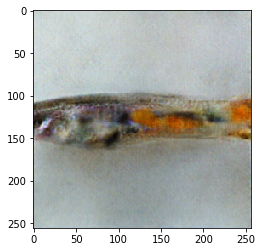

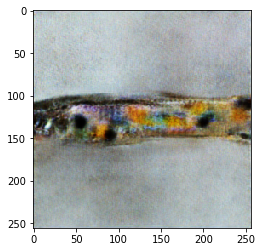

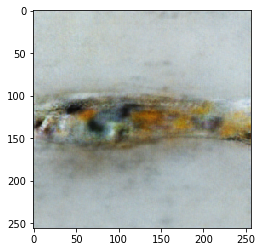

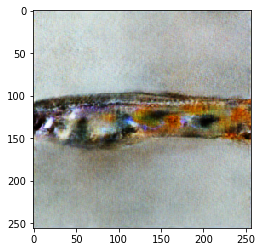

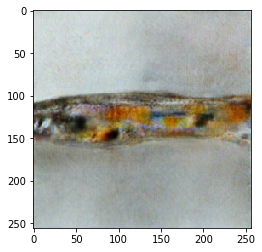

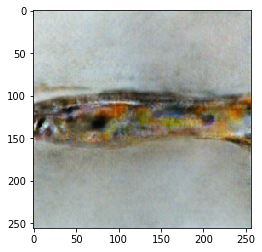

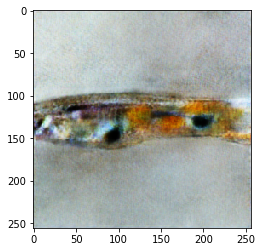

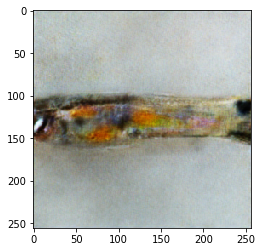

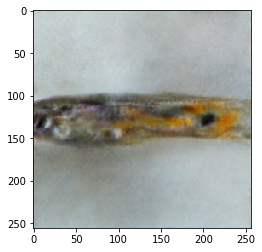

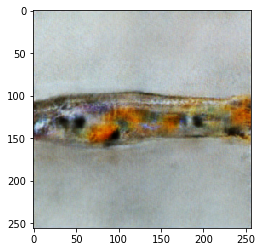

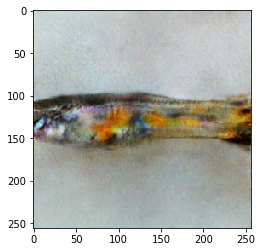

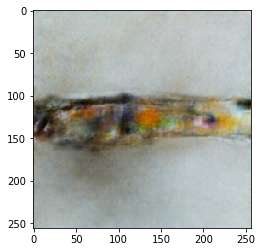

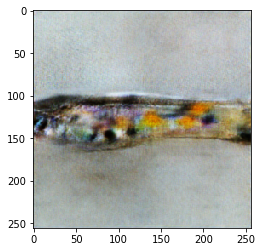

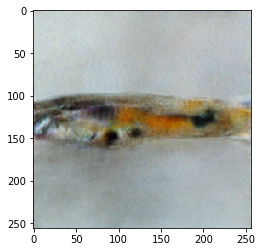

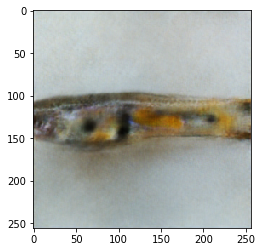

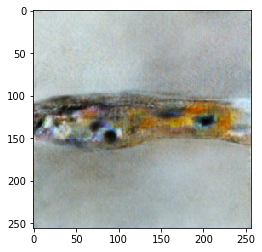

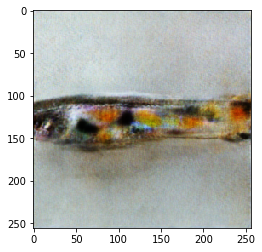

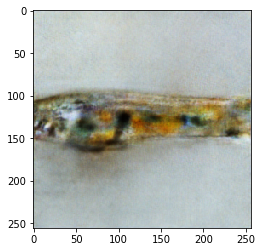

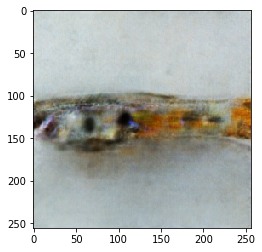

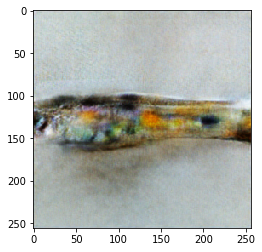

In [57]:
sample = [np.random.multivariate_normal([0] * latent_size, np.diag([1] * latent_size), 20)] * 4
generated = vlae.get_layer('decoder').predict(sample)
generated = generated.reshape((20, 256, 256,3))

for i in range(20):
    img = generated[i]
    plt.imshow(img)
    plt.show()

In [124]:
real_images = np.load("/home/etheredge/Workspace/tcvae/data/imgs_trainVAE.npy")
real_labels = np.load("/home/etheredge/Workspace/tcvae/data/lines_trainVAE.npy")


In [125]:
# real_images = brooks_images
# real_labels = brooks_attrs[:,1]

In [126]:
images[0].shape

(256, 256, 3)

In [127]:
import umap
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import itertools

In [145]:
h_0 = []
h_1 = []
h_2 = []
h_3 = []
for image in gan_images:
    x = vlae.get_layer('encoder').predict(np.expand_dims(image, axis=0));
    h_0.append(vlae.get_layer('z_1_latent')(x[0]))
    h_1.append(vlae.get_layer('z_2_latent')(x[1]))
    h_2.append(vlae.get_layer('z_3_latent')(x[2]))
    h_3.append(vlae.get_layer('z_4_latent')(x[3]))


In [148]:

h_3 = np.array(h_3)
h_3 = h_3.reshape(gan_images.shape[0],latent_size)

h_2 = np.array(h_2)
h_2 = h_2.reshape(gan_images.shape[0],latent_size)

h_1 = np.array(h_1)
h_1 = h_1.reshape(gan_images.shape[0],latent_size)

h_0 = np.array(h_0)
h_0 = h_0.reshape(gan_images.shape[0],latent_size)

In [149]:
np.save('data/interim/h_3_gan', h_3)
np.save('data/interim/h_2_gan', h_2)
np.save('data/interim/h_1_gan', h_1)
np.save('data/interim/h_0_gan', h_0)

In [153]:
fig = plt.figure(figsize=(100,25))
for i, h in enumerate([h_0, h_1, h_2, h_3]):
    ax = plt.subplot(1,4,i+1, sharex=True, sharey=True)
    embedding = TSNE(n_components=2).fit_transform(Z)
    scatter = imscatter(embedding[:, 0], embedding[:, 1], gan_images, zoom=0.1, ax=ax)
    ax.set_title('Level {}'.format(i+1))
fig = plt.gcf()
fig.savefig('reports/figures/panels/vlae_embedding_gan_images.pdf', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)

TypeError: cannot create weak reference to 'bool' object

<Figure size 8000x2000 with 0 Axes>

<Figure size 8000x2000 with 0 Axes>

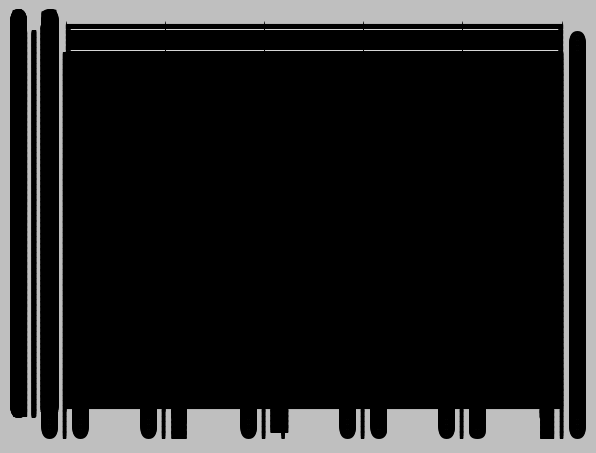

In [139]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.style.use('classic')
plt.rcParams.update({'font.size': 30})

Z = h_3
# reducer = umap.UMAP(random_state=2, n_neighbors=30)
# embedding = reducer.fit_transform(Z)
embedding = TSNE(n_components=2).fit_transform(Z)
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca();
    try:
        image = plt.imread(image);
    except TypeError:
        # Likely already an array...
        pass
    x, y = np.atleast_1d(x, y);
    artists = [];
    for i, (x0, y0) in enumerate(zip(x, y)):
        im = OffsetImage(image[i], zoom=zoom);
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False);
        artists.append(ax.add_artist(ab));
    ax.update_datalim(np.column_stack([x, y]));
    ax.autoscale();
    ax.grid(False);
    return artists
fig, ax = plt.subplots(figsize=(100,25));
imscatter(embedding[:, 0], embedding[:, 1], real_images, zoom=0.1, ax=ax);

In [85]:
def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z


/home/etheredge/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


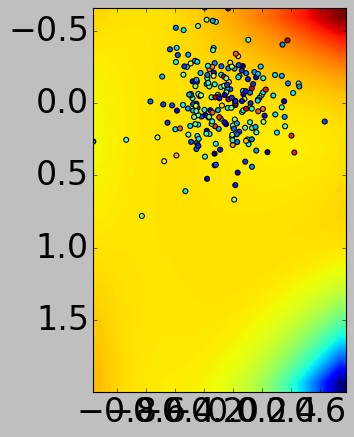

In [126]:
L = brooks_attrs[:,1]
# Z = np.concatenate([h_0, h_1, h_2, h_3],axis=1)
Z = h_3
# Z = attrs[:,2:]
# reducer = umap.UMAP(random_state=2)
reducer = PCA(n_components=2)
embedding = reducer.fit_transform(Z)
x = embedding[:, 0]
y = embedding[:, 1]
z = L
m = polyfit2d(x, y, z)
nx, ny = 20, 20
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), nx), 
                     np.linspace(y.min(), y.max(), ny))
zz = polyval2d(xx, yy, m)

plt.scatter(x, y, c=z)
plt.imshow(zz, extent=(x.min(), y.max(), x.max(), y.min()))

plt.show()

# Future improvements
* Use the label as additional information to improve the recostruction